Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.6646 - binary_accuracy: 0.6927 - val_loss: 0.6157 - val_binary_accuracy: 0.7702
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5485 - binary_accuracy: 0.8004 - val_loss: 0.4984 - val_binary_accuracy: 0.8212
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4450 - binary_accuracy: 0.8443 - val_loss: 0.4201 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3779 - binary_accuracy: 0.8662 - val_loss: 0.3739 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3358 - binary_accuracy: 0.8794 - val_loss: 0.3451 - val_binary_accuracy: 0.8672
Epoch 6/10
625/625 [=====

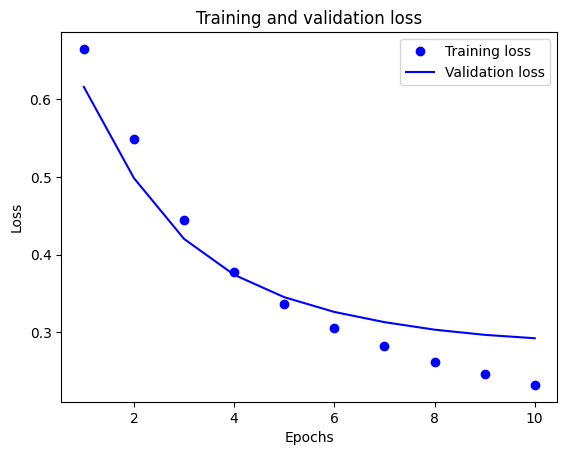

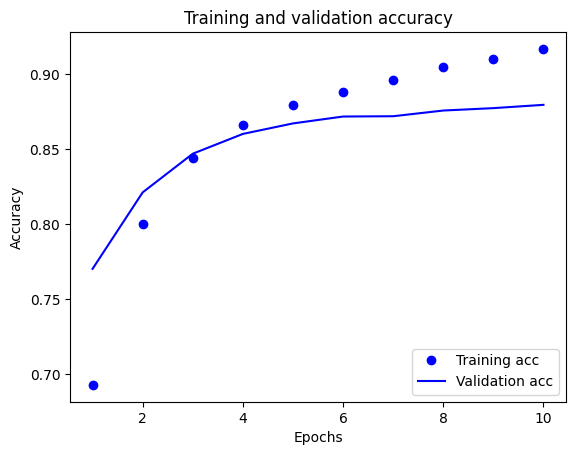

782/782 [==============================] - 7s 8ms/step - loss: 0.3098 - accuracy: 0.8739
0.8739200234413147
1/1 [==============================] - 0s 154ms/step


array([[0.6225909 ],
       [0.44617465],
       [0.36160305]], dtype=float32)

In [9]:
# 영화 리뷰를 사용한 텍스트 분류
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

# 감정 분석
## 데이터셋(IMDB) 다운로드 및 탐색
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImb_v1", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
# os.listdir(dataset_dir)

train_dir = os.path.join(dataset_dir, "train")
# os.listdir(train_dir)

# sample_file = os.path.join(train_dir, "pos/1181_9.txt")
# with open(sample_file) as f:
#     print(f.read())

## 데이터셋 로드
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

# 머신러닝 실험을 실행할 땐 데이터셋을 train, validation, test의 세 부분으로 나누는 것이 가장 좋음.
# IMDB 데이터셋은 검증 셋이 부족해 훈련 데이터를 80:20으로 분할해 검증 셋 생성
batch_size = 32
seed = 42               # 검증 및 훈련 분할이 겹치지 않도록 임의 시드 설정 (or shuffle=False 전달)

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)

# for text_batch, label_batch in raw_train_ds(1):
#     for i in range(3):
#         print("Review: ", text_batch.numpy()[i])
#         print("Label: ", label_batch.numpy()[i])

# print("Label 0 corresponds to", raw_train_ds.class_names[0])
# print("Label 1 corresponds to", raw_train_ds.class_names[1])

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

## 훈련을 위한 데이터셋 준비
# 표준화 : 구두점이나 HTML 요소를 제거하여 데이터셋을 단순화하기 위한 텍스트 전처리 과정
# 토큰화 : 문자열을 여러 토큰으로 분할
# 벡터화 : 토큰을 숫자로 변환해 신경망에 공급할 수 있도록 함
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html,
                                    "[%s]" % re.escape(string.punctuation),
                                    "")

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,         # 표준화
    max_tokens=max_features,                    # 토큰화
    output_mode="int",                          # 벡터화
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
# text_batch, label_batch = next(iter(raw_train_ds))
# first_review, first_label = text_batch[0], label_batch[0]
# print("Review: ", first_review)
# print("Label: ", raw_train_ds.class_names[first_label])
# print("Vectorized review: ", vectorize_text(first_review, first_label))

# print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
# print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
# print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


## 성능을 높이도록 데이터셋 구성
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델 생성
embedding_dim = 16

model = tf.keras.Sequential([
    # 정수로 인코딩된 리뷰를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾음.
    # 벡터는 모델이 훈련되면서 학습, 출력 배열에 차원을 추가해 최종 차원은 (batch, sequence, embedding)
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    # sequence 차원에 대해 평균을 계산해 각 샘플에 대해 고정된 길이의 출력 벡터 반환
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

# model.summary(0)

## 손실 함수와 옵티마이저
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## 모델 훈련
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

## 모델 평가
# loss, accuracy = model.evaluate(test_ds)

# print("Loss: ", loss)
# print("Accuracy: ", accuracy)

## 정확도와 손실 그래프 그리기
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, "bo", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

# 모델 내보내기
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=['accuracy']
)

# Test it with 'raw_test_ds', which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

## 새로운 데이터로 추론
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible..."
]

export_model.predict(examples)